<a href="https://colab.research.google.com/github/osgeokr/torchgeo-explained/blob/main/TorchGeo_Object_Detection_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchGeo: An Introduction to Object Detection Example

[TorchGeo](https://torchgeo.readthedocs.io/en/stable/) is a PyTorch domain library similar to torchvision, specialized for geospatial data. It offers datasets, samplers, transformations, and pre-trained models tailored for geospatial information. This tutorial will introduce an object detection example in TorchGeo.

This example is based on the notebook [torchgeo_object_detection_example.ipynb](https://gist.github.com/calebrob6/d32673997661a75d1a5e2e5c0afbe68a) provided by Caleb Robinson from Microsoft AI for Good, with added explanations.

## GPU Selection

Before starting the training, select Runtime > Change runtime type from the notebook's top menu, then choose GPU from the Hardware accelerator menu and save. I subscribe to Colab Pro and used an A100 GPU.

## Installing TorchGeo

TorchGeo installs only a set of essential dependencies by default with `pip install torchgeo` to keep the installation relatively lightweight. For a full installation that includes an optional set of dependencies, you can use `pip install torchgeo[datasets]`.

- `pip install torchgeo`: Installs the "Required" set of dependencies.
- `pip install torchgeo[datasets]`: Full installation that includes the "Optional" set of dependencies.

In [ ]:
%pip install -q -U torchgeo[datasets]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.1/381.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.0/741.0 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

## Installing PyTorch Lightning

[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) offers a high-level interface for PyTorch, simplifying and streamlining the model training process.

In [ ]:
!pip install -q -U pytorch-lightning

## Downloading the VHR-10 Dataset

The [VHR-10](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#vhr-10) dataset, provided by Northwestern Polytechnical University (NWPU) in China, is a Very High Resolution (VHR) remote sensing image dataset encompassing 10 classes.

Comprising a total of 800 VHR optical remote sensing images, 715 of these color images were acquired from Google Earth with spatial resolutions ranging from 0.5 to 2 meters. The remaining 85 pan-sharpened Color InfraRed (CIR) images, derived from the [Vaihingen dataset](https://www.isprs.org/education/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx), boast a spatial resolution of 0.08 meters.

  > Note: [Pan-sharpening](https://earthobservatory.nasa.gov/blogs/earthmatters/2017/06/13/how-to-pan-sharpen-landsat-imagery/) is a technique that combines the high-resolution detail of the panchromatic band with the lower resolution color information of other bands.

The dataset is divided into two sets:
- Positive image set (650 images): Images containing at least one object.
- Negative image set (150 images): Images without any objects.

The positive image set includes objects from the following ten classes:
- Airplanes (757 instances)
- Ships (302 instances)
- Storage tanks (655 instances)
- Baseball diamonds (390 instances)
- Tennis courts (524 instances)
- Basketball courts (159 instances)
- Ground track fields (163 instances)
- Harbors (224 instances)
- Bridges (124 instances)
- Vehicles (477 instances)

The dataset includes object detection bounding boxes and instance segmentation masks.

When using this dataset for research, please cite the following papers:
- https://doi.org/10.1016/j.isprsjprs.2014.10.002
- https://doi.org/10.1109/IGARSS.2019.8898573
- https://doi.org/10.3390/rs12060989

Import the necessary libraries and download the VHR-10 dataset.

In [ ]:
import torchgeo
from torchgeo.datasets import VHR10
from torchgeo.trainers import ObjectDetectionTask

import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl

import matplotlib.pyplot as plt

In [ ]:
import os, gdown

os.makedirs('data/VHR10/', exist_ok=True)

url = 'https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE'
output_path = 'data/VHR10/NWPU VHR-10 dataset.rar'
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE
From (redirected): https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE&confirm=t&uuid=0d3d548b-de70-487f-8398-2109eeb71eb2
To: /content/data/VHR10/NWPU VHR-10 dataset.rar
100%|██████████| 76.8M/76.8M [00:03<00:00, 23.5MB/s]


'data/VHR10/NWPU VHR-10 dataset.rar'

The code below downloads the `VHR10` dataset to the `data/VHR10/` location with the 'positive' split, and applies transformations using a given preprocessing function. The role of the `preprocess` function is to convert each image to a floating-point type and normalize the values to be between 0 and 1 by dividing by 255. This process helps prepare the data in a form suitable for model training.

In [ ]:
def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

ds = VHR10(
    root="data/VHR10/",
    split="positive",
    transforms=preprocess,
    download=True,
    checksum=True,
)

Using downloaded and verified file: data/VHR10/NWPU VHR-10 dataset.rar
Extracting data/VHR10/NWPU VHR-10 dataset.rar to data/VHR10/


100%|██████████| 1265416/1265416 [00:00<00:00, 213660456.12it/s]

loading annotations into memory...


Done (t=0.03s)
creating index...
index created!


## Exploring the VHR-10 Dataset

Let's now take a look at the positive image set. There are a total of 650 images.

In [ ]:
print(f"VHR-10 dataset: {len(ds)}")

VHR-10 dataset: 650


Access the first item in the `ds` dataset and check the dimensions of the image corresponding to the `"image"` key. The `shape` attribute returns the dimensions of the image, which are represented in the format (number of channels, height, width).

In [ ]:
ds[0]["image"].shape

torch.Size([3, 808, 958])

Let's open the image of the sixth item at random. Change the dimensions of the image from (number of channels, height, width) to (height, width, number of channels) before displaying it.

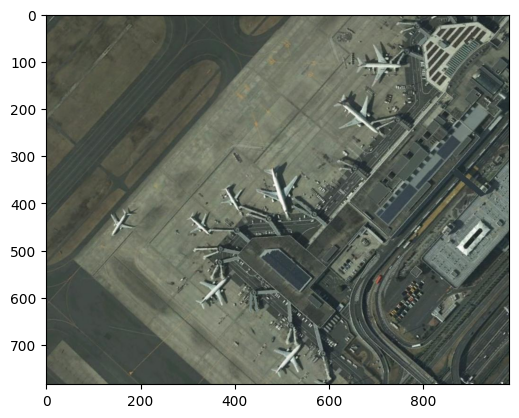

In [ ]:
image = ds[5]["image"].permute(1, 2, 0)
plt.imshow(image)
plt.show()

The VHR10 dataset in TorchGeo includes a `plot` method that visualizes annotations contained in `annotations.json`. These annotations provide information for object detection and instance segmentation, including visual elements like bounding boxes and masks. This allows for direct visualization of images with ground truth annotations marked on them.

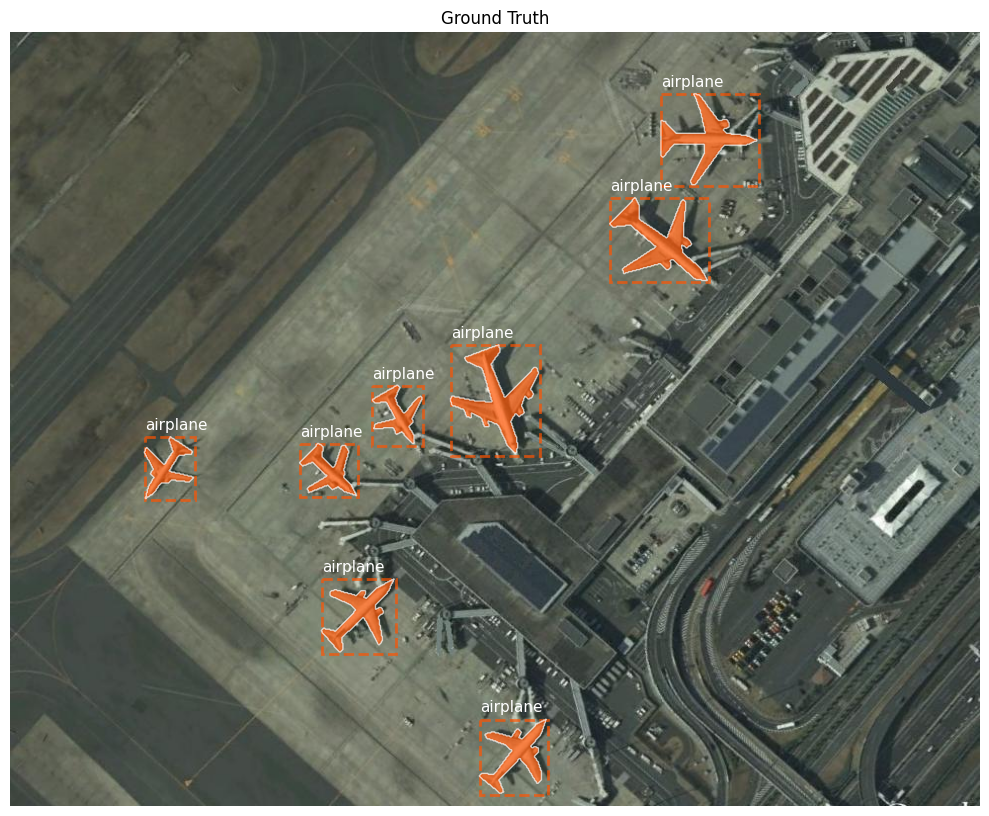

In [ ]:
ds.plot(ds[5])
plt.savefig('ground_truth.png', bbox_inches='tight')
plt.show()

## Model Training

The following demonstrates the process of using PyTorch's DataLoader to define a `collate_fn` function and utilize it to load data:
  > The `collate_fn` function extracts the image, boxes, labels, and masks from each item in a given batch and constructs a new batch dictionary. This newly constructed batch is then directly used for model training or evaluation. The DataLoader prepares the data in batch units for the model using this function. The option `shuffle=True` randomly shuffles the order of the dataset to reduce dependency on the sequence of data during model training.

In [ ]:
def collate_fn(batch):
    new_batch = {
        "image": [item["image"] for item in batch],  # Images
        "boxes": [item["boxes"] for item in batch],  # Bounding boxes
        "labels": [item["labels"] for item in batch],  # Labels
        "masks": [item["masks"] for item in batch],  # Masks
    }
    return new_batch  # Return the new batch

# Data Loader

dl = DataLoader(
    ds,  # Dataset
    batch_size=32,  # Number of data to load at one time
    num_workers=2,  # Number of processes to use for data loading
    shuffle=True,  # Whether to shuffle the dataset before loading
    collate_fn=collate_fn,  # collate_fn function for batch processing
)

This code defines a training class for object detection tasks and creates an instance of it. Importantly, the class is designed to handle variable-sized inputs.

  > The `VariableSizeInputObjectDetectionTask` class inherits from a standard `ObjectDetectionTask` and defines the `training_step` method to process variable-sized input images within each batch. This allows the model to effectively learn from input images of various sizes. The created instance is prepared to perform object detection tasks using the Faster R-CNN model with specified settings.

In [ ]:
class VariableSizeInputObjectDetectionTask(ObjectDetectionTask):
    # Define the training step
    def training_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch["image"]  # Image
        batch_size = len(x)  # Set batch size (number of images)
        y = [
            {"boxes": batch["boxes"][i], "labels": batch["labels"][i]}
            for i in range(batch_size)
        ] # Extract bounding box and label information for each image
        loss_dict = self(x, y)  # Loss
        train_loss: Tensor = sum(loss_dict.values())  # Training loss (sum of loss values)
        self.log_dict(loss_dict)  # Record loss values
        return train_loss  # Return training loss

task = VariableSizeInputObjectDetectionTask(
    model="faster-rcnn",  # Faster R-CNN model
    backbone="resnet18",  # ResNet18 neural network architecture
    weights=True,  # Use pretrained weights
    in_channels=3,  # Number of channels in the input image (RGB images)
    num_classes=11,  # Number of classes to classify (10 + background)
    trainable_layers=3,  # Number of trainable layers
    lr=1e-3,  # Learning rate
    patience=10,  # Set the number of patience iterations for early stopping
    freeze_backbone=False,  # Whether to train with the backbone network weights unfrozen
)
task.monitor = "loss_classifier"  # Set the metric to monitor (here, the classifier's loss)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


Prepare the configuration for model training using the PyTorch Lightning library. The settings below specify training the model with GPU, saving training logs and checkpoints to the 'logs/' directory, and setting the training to run for a minimum of 6 epochs and a maximum of 100 epochs.

In [ ]:
trainer = pl.Trainer(
    default_root_dir="logs/",  # Set the default directory
    accelerator="gpu",  # Set the type of hardware accelerator for training (using GPU)
    devices=[0],  # List of device IDs to use ([0] means the first GPU)
    min_epochs=6,  # Set the minimum number of training epochs
    max_epochs=100,  # Set the maximum number of training epochs
    log_every_n_steps=20,  # Set how often to log after a number of steps
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%%time
# Model training
trainer.fit(task, train_dataloaders=dl)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Model Inference Example

Retrieve the next batch from the data loader (`dl`).

In [ ]:
batch = next(iter(dl))

Obtain the model from the task (`task`) and set it to evaluation mode. This action deactivates specific layers, such as Dropout, that are used during training. Dropout is a highly effective regularization technique designed to prevent overfitting in neural networks.

Using `torch.no_grad()` disables gradient calculations, reducing memory usage and increasing computation speed. This is utilized when the model is not being updated during evaluation or inference phases. Now, pass the image batch through the model to obtain the prediction results.

In [ ]:
model = task.model
model.eval()

with torch.no_grad():
  out = model(batch["image"])

Define a sample for a specific batch index.

In [ ]:
def create_sample(batch, out, batch_idx):
    return {
        "image": batch["image"][batch_idx],  # Image
        "boxes": batch["boxes"][batch_idx],  # Actual bounding boxes
        "labels": batch["labels"][batch_idx],  # Actual labels
        "masks": batch["masks"][batch_idx],  # Actual masks
        "prediction_labels": out[batch_idx]["labels"],  # Labels predicted by the model
        "prediction_boxes": out[batch_idx]["boxes"],  # Bounding boxes predicted by the model
        "prediction_scores": out[batch_idx]["scores"],  # Confidence scores for each prediction
    }

batch_idx = 0
sample = create_sample(batch, out, batch_idx)

Now, visualize the given sample. The plot method visualizes the image included in the sample, along with the actual labels and bounding boxes, and the predicted labels and bounding boxes.

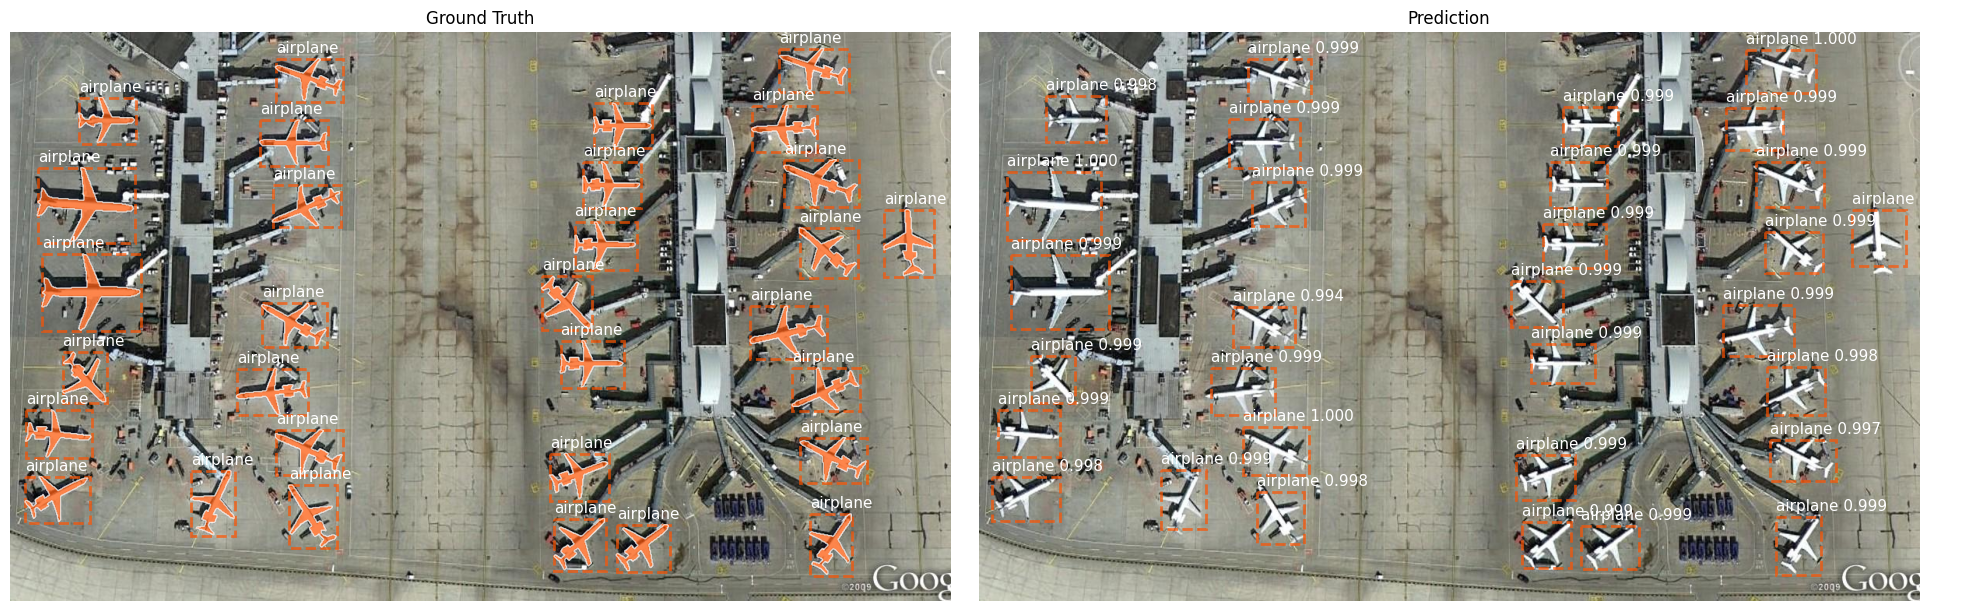

In [ ]:
ds.plot(sample)
plt.savefig('inference.png', bbox_inches='tight')
plt.show()

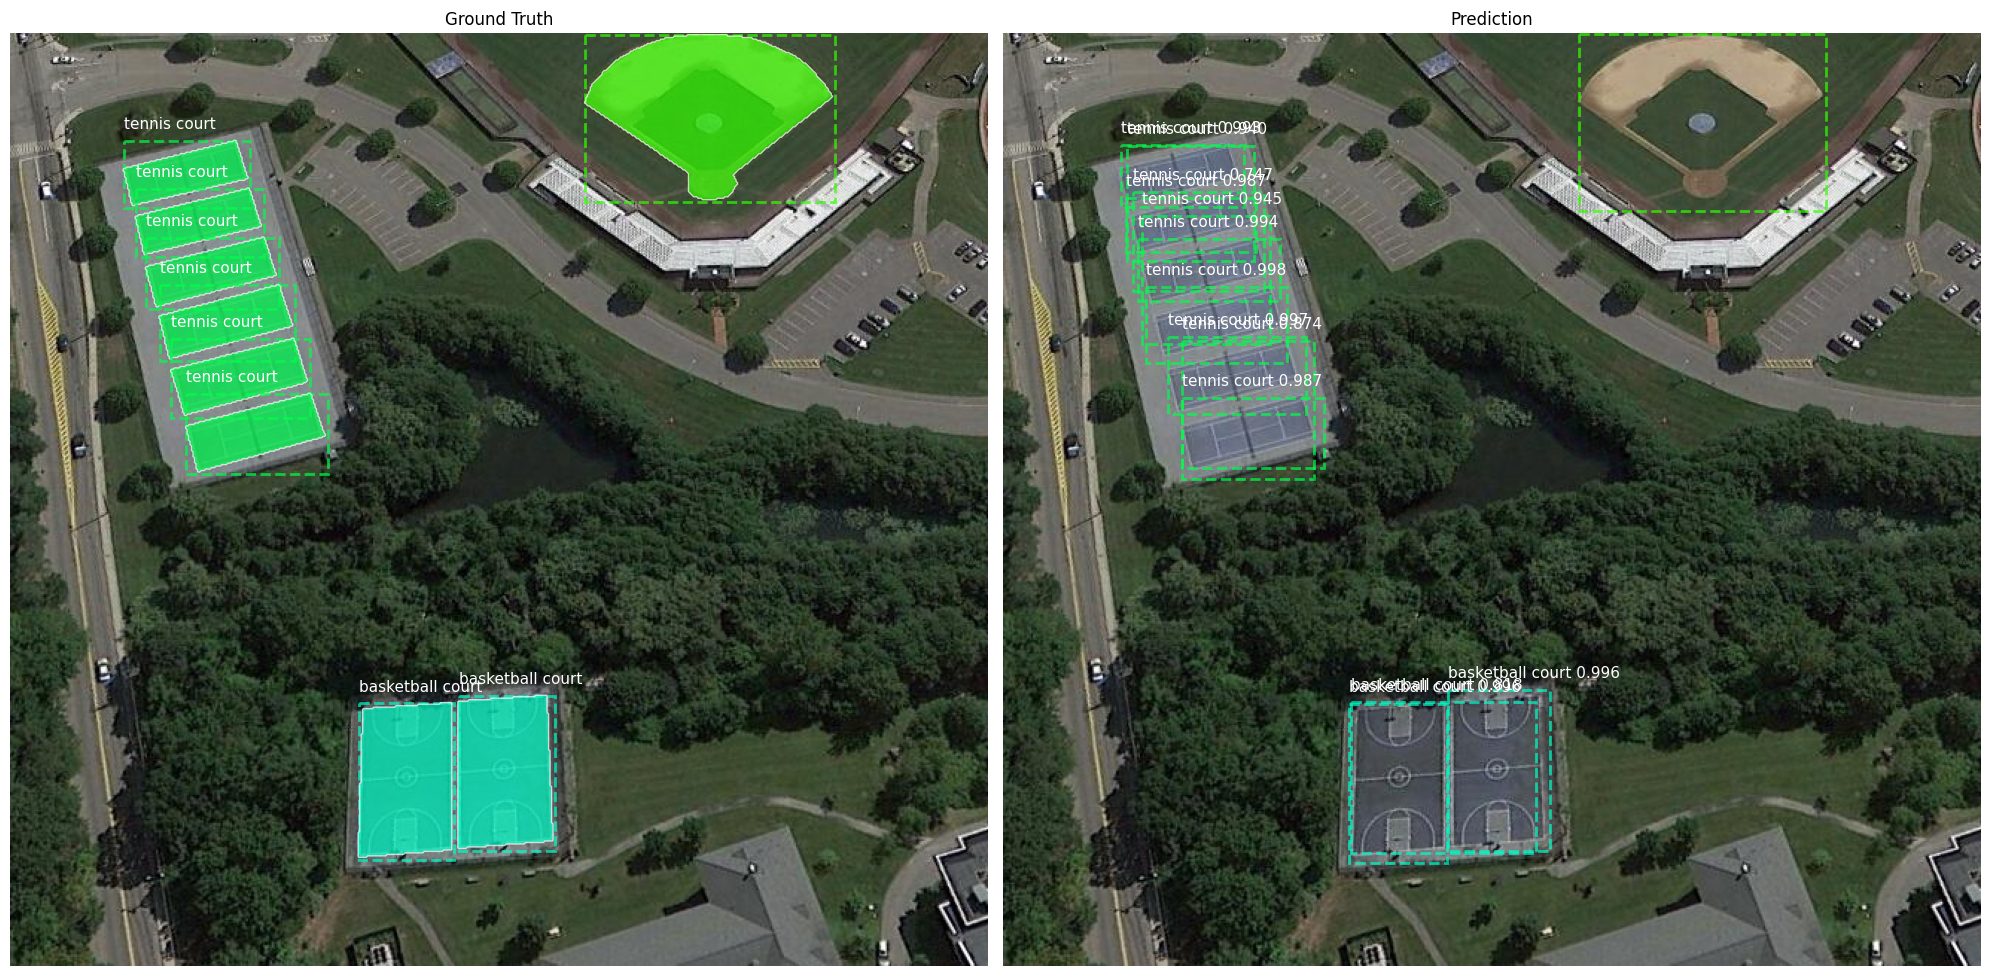

In [ ]:
# Visualizing Sample for Batch Index 3
batch_idx = 3
sample = create_sample(batch, out, batch_idx)

ds.plot(sample)
plt.show()

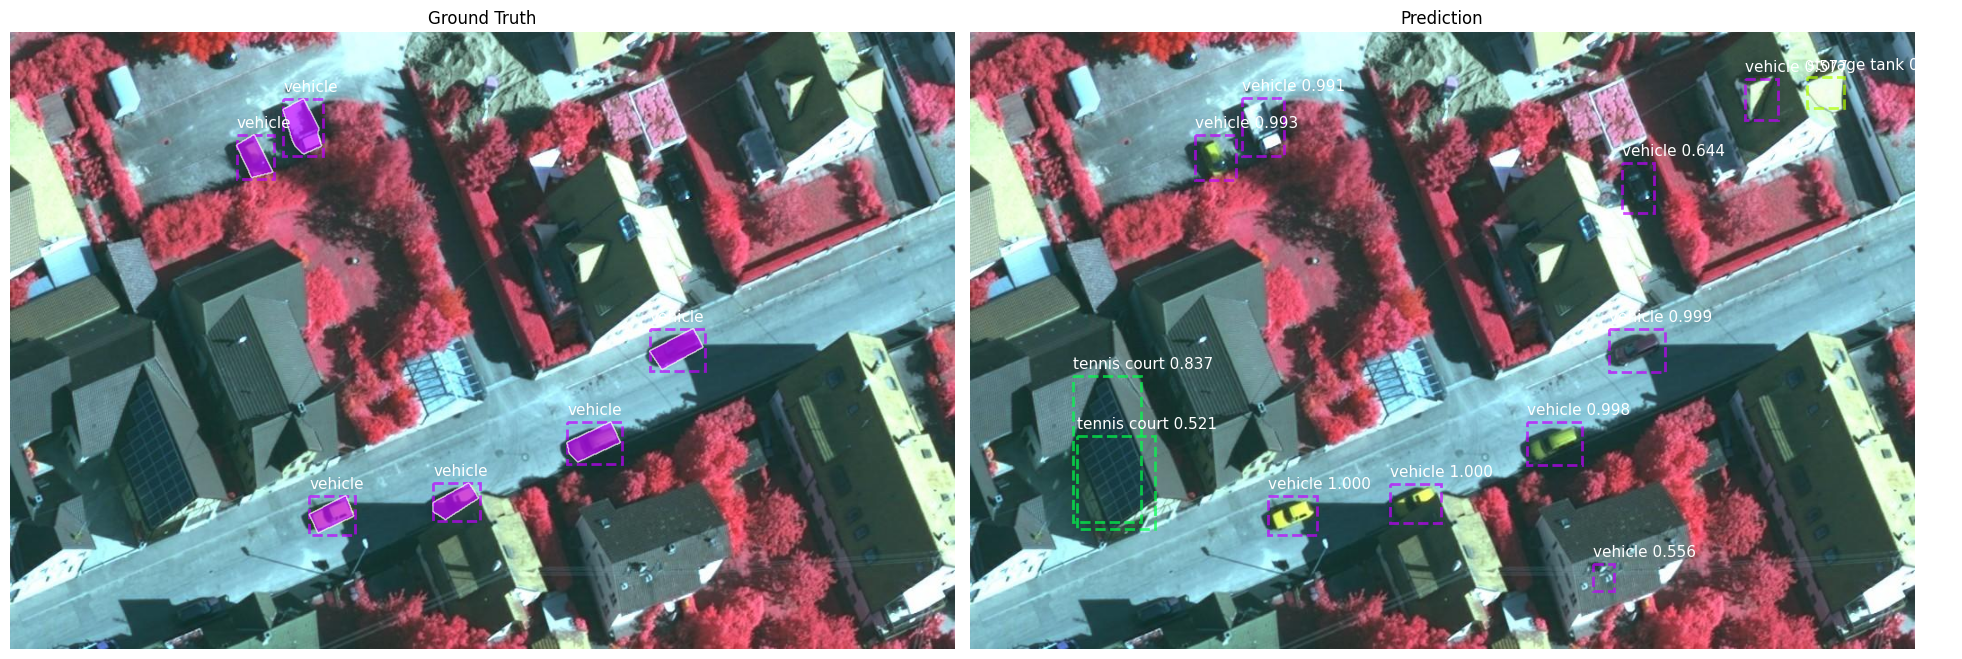

In [ ]:
# Visualizing Sample for Batch Index 5
batch_idx = 5
sample = create_sample(batch, out, batch_idx)

ds.plot(sample)
plt.show()